In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import os
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import scipy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
import xgboost as xgb
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
phone_accel_df = pd.DataFrame()
filenames = os.listdir('wisdm-dataset/arff_files/phone/accel')
filenames.pop(0)
for file in filenames:
    path = "wisdm-dataset/arff_files/phone/accel/" + file
    data = arff.loadarff(path)
    df = pd.DataFrame(data[0])
    print("for file at " + path + "shape is: " + str(df.shape))
    frames = [df, phone_accel_df]
    phone_accel_df = pd.concat(frames, sort = False)
    
print(phone_accel_df.shape)
    
phone_accel_old_column_names = phone_accel_df.columns

phone_accel_new_column_names = []
for name in phone_accel_old_column_names:
    phone_accel_new_column_names.append(name.replace('"', ''))
    
replacement_dict = dict(zip(phone_accel_old_column_names, phone_accel_new_column_names))
phone_accel_df = phone_accel_df.rename(columns = replacement_dict)
#phone_accel_df.head()

labelencoder = LabelEncoder()
phone_accel_df['ACTIVITY'] = labelencoder.fit_transform(phone_accel_df['ACTIVITY'])
#phone_accel_df.head()

phone_accel_df.pop('class')

phone_accel_df_shuffle = shuffle(phone_accel_df)

phone_accel_data = phone_accel_df_shuffle.to_numpy()

X_phone_accel = phone_accel_data[:,1:]
Y_phone_accel = phone_accel_data[:,0]
print(X_phone_accel.shape)
print(Y_phone_accel.shape)

x_train, x_test, y_train, y_test = train_test_split(X_phone_accel, Y_phone_accel, test_size = 0.35)
#x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.40)

for file at wisdm-dataset/arff_files/phone/accel/data_1600_accel_phone.arffshape is: (321, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1601_accel_phone.arffshape is: (407, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1602_accel_phone.arffshape is: (424, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1603_accel_phone.arffshape is: (409, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1604_accel_phone.arffshape is: (321, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1605_accel_phone.arffshape is: (406, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1606_accel_phone.arffshape is: (321, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1607_accel_phone.arffshape is: (383, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1608_accel_phone.arffshape is: (482, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1609_accel_phone.arffshape is: (306, 93)
for file at wisdm-dataset/arff_files/phone/accel/d

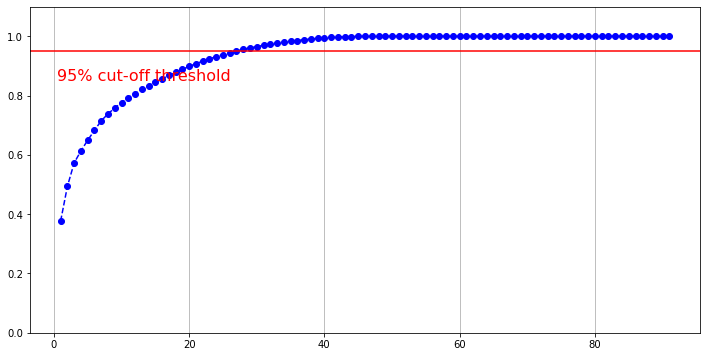

In [4]:
x_pca = StandardScaler().fit_transform(x_train)

pca = PCA().fit(x_pca)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 92, step=1)
yi = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize = 16)

ax.grid(axis='x')
plt.show()

In [5]:
pca = PCA(n_components = 28)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
#x_val_pca = pca.transform(x_val)

In [6]:
space = {
    "n_estimators": hp.choice("n_estimators", [100, 150, 200, 250, 300, 350, 400, 450, 500]),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    "min_samples_split": hp.choice("min_samples_split", [2, 3, 4, 5, 6, 7, 8, 9, 10]),
    "max_features": hp.choice("max_features", ["auto","sqrt","log2"]),
}

In [7]:
def hyperparameter_tuning(space):
    clf = RandomForestClassifier(n_estimators = int(space['n_estimators']), max_depth = space['max_depth'], 
                                 criterion = space['criterion'], min_samples_split = int(space['min_samples_split']),
                                 max_features = space['max_features'],n_jobs=-1)
    acc = cross_val_score(clf, x_train_pca, y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

In [ ]:
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best))

 61%|█████████████████████████                | 61/100 [1:16:55<1:26:49, 133.57s/trial, best loss: -0.8287099477603647]

In [ ]:
clf = RandomForestClassifier(criterion = 'entropy', max_depth = 15, max_features = 'auto', min_samples_split = 4, 
                             n_estimators = 450, n_jobs = -1)

clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Train accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

In [ ]:
print("average = Nonen: ", precision_score(y_test, y_test_pred, average = None))
print("average = micro: ", precision_score(y_test, y_test_pred, average = 'micro'))
print("average = macro: ", precision_score(y_test, y_test_pred, average = 'macro'))
print("average = weighted: ", precision_score(y_test, y_test_pred, average = 'weighted'))

In [ ]:
print("average = Nonen: ", recall_score(y_test, y_test_pred, average = None))
print("average = micro: ", recall_score(y_test, y_test_pred, average = 'micro'))
print("average = macro: ", recall_score(y_test, y_test_pred, average = 'macro'))
print("average = weighted: ", recall_score(y_test, y_test_pred, average = 'weighted'))